In [194]:
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits

# Helper functions for storing data (spectra) and performing the fits (fitting)
from spectra import *
from fitting import *

## Import normalized spectrum

[Nyquist sampling] Factor applied: 3. Old SNR = 86.94458325323579
[Nyquist sampling] Factor applied: 3. New SNR = 148.89835243227193


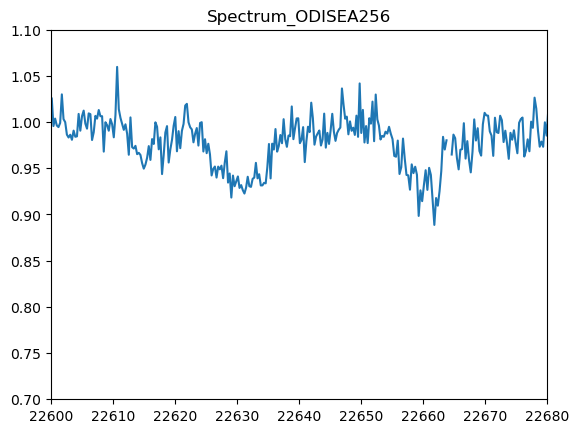

In [195]:
fname = "data/science/Spectrum_ODISEA256.nspec"

# ProplydData is a simple class that stores the data and has some built-in methods
# to help with data processing
obj = ProplydData(fname)

# Let's nyquist sample the data. This assumes that we are using iSHELL 0.75'' slit width with is
# over sampled by 6 pixels per resolution element. We are bring it down to 2 (Nyquist)
obj.Nyquist_bin_spectrum(N = 3)

obj.x *= 1  #e4  # convert x-axis to angstroms

plt.figure()
plt.plot(obj.x, obj.y)
plt.ylim(0.7, 1.1)
plt.xlim(22600, 22680)
plt.title(obj.name)  # the object name was automatically set from the file name - see ProplyData.__init__()
plt.show()

## Finding doppler shifts by hand

I set up a dictionary that will be converted to a CSV file later. I also find the Doppler shifts by hand in region 5 here. For now, I use the same shift for all regions. Later, you can see that the shifts are slightly off between wavelength regions.

The process for finding doppler shifts should probably be automated by doing some sort of cross-correlation.

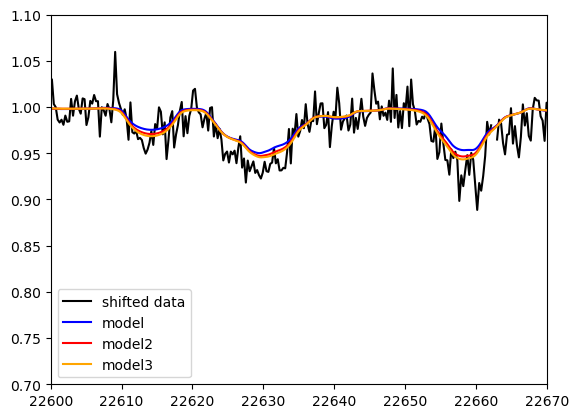

In [196]:
shift = -6  # shift in units of array indices
xlo, xhi = 22600, 22670  # wavelength region for plotting

# Visually determine the doppler shift by plotting against a test model
# and shifting the data to match the model

obj_test = copy.deepcopy(obj)  # make a copy of the data while testing the doppler shift
obj_test.doppler_shift_data(shift)  # apply the doppler shift
# xdata, ydata, yerrdata = obj_test.get_range(xlo, xhi)  # get

# example model
model = MoogStokesModel(3600, 2.50, rK=3, B=1, vsini=52, region=5)
model2 = MoogStokesModel(3600, 3.00, rK=3, B=1, vsini=52, region=5)
model3 = MoogStokesModel(3600, 3.25, rK=3, B=1, vsini=52, region=5)

plt.figure()
plt.plot(obj_test.x, obj_test.y, c='k', label="shifted data")
plt.plot(model.x, model.y, c='blue', label="model")
plt.plot(model2.x, model2.y, c='red', label="model2")
plt.plot(model3.x, model3.y, c='orange', label="model3")

plt.legend()
plt.xlim(xlo, xhi)
plt.ylim(0.7, 1.1)
plt.show()

In [197]:
## When you're ready, apply the doppler shift to the original data
obj.doppler_shift_data(shift)  

# errors can also be re-scaled to a value that is appropriate depending on the reduced chi-squared
obj.rescale_yerr(2.67)

[yerr rescaled] Factor applied: 2.67. Total scaling so far: 2.67


## Fit the object across a grid with minimum chi-squared

This cell computes the chi-squared value for every model across the grid. NOTE: The grid search scales as n^5 so it will take a long time if the grid is large!

In [198]:
# Define the range of values for the grid. The sampling is coarse in this example.
Teff_vals = np.arange(3200, 4001, 200)
logg_vals = np.array([2.5,3.0,3.25,3.5])#np.arange(2.5, 3.50, 0.25)
rK_vals = np.arange(1.0, 4.0, 0.2)
vsini_vals = np.arange(47, 60, 5)
B_vals = np.arange(0.0, 3.0, 0.5)

# Which wavelength regions should we fit? The regions are defined in the object spectra.MoogStokesModel.region_xlims().
# For example, setting regions = [0, 1, 2, 4, 5, 6] will skip region 3. This is useful if there are no lines in that
# region for the data.
regions = [0, 1, 2, 3, 4, 5, 6] #range(7)

# Fit the model across the grid - MAY TAKE A WHILE
chi2_grid = compute_moogstokes_chi2_grid(obj, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals, regions=regions)


In [199]:
# The variable chi2_grid contains the chi-squared values across the grid. If you want to get the model parameters
# that correspond to the lowest chi-squared, you can use this function
Teff_best, logg_best, rK_best, vsini_best, B_best = best_chi2_grid_params(chi2_grid, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals)

## Plot the best fit model

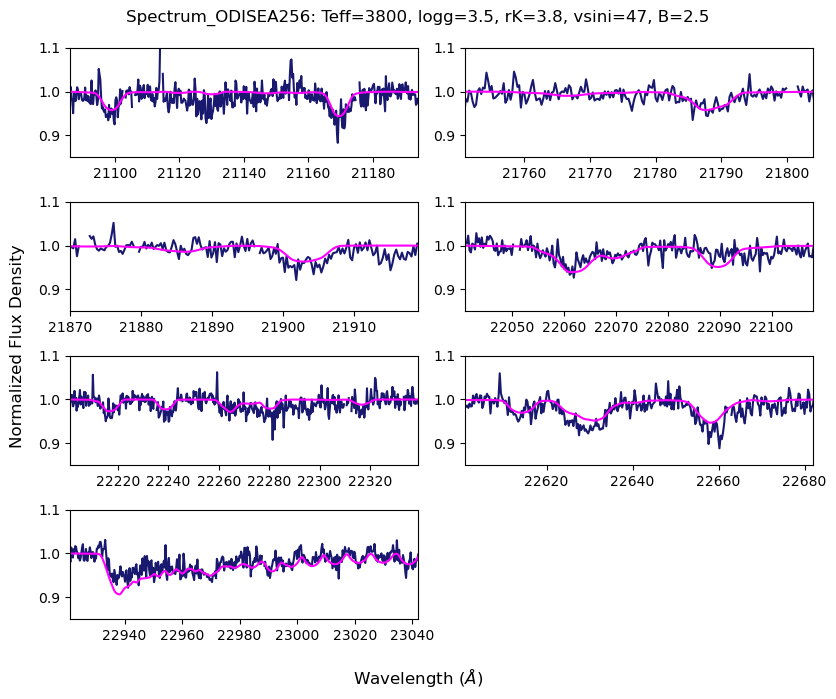

In [200]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8.5,7))

for r, ax in enumerate(axs.reshape(-1)):
    if r == 7:
        ax.axis("off")
        continue

    # This is the best model we found
    model = MoogStokesModel(Teff=Teff_best, logg=logg_best, rK=rK_best, B=B_best, vsini=vsini_best, region=r)
    
    ax.plot(obj.x, obj.y, c='midnightblue')
    ax.plot(model.x, model.y, c='magenta')
    ax.set_ylim(0.85,1.1)

    xlo, xhi = model.region_xlims(r)
    ax.set_xlim(xlo,xhi)
    
fig.suptitle(f"{obj.name}: Teff={model.Teff}, logg={model.logg}, rK={round(model.rK,2)}, vsini={model.vsini}, B={model.B}")
fig.supxlabel(r"Wavelength ($\AA$)")
fig.supylabel(r"Normalized Flux Density")
plt.tight_layout()
fig.savefig(f"figures/model_plots/{obj.name}_Regions{regions}_Teff{model.Teff}_logg{model.logg}_rK{round(model.rK,2)}_vsini{model.vsini}_B{model.B}.png", dpi=98, facecolor="white")
plt.show()

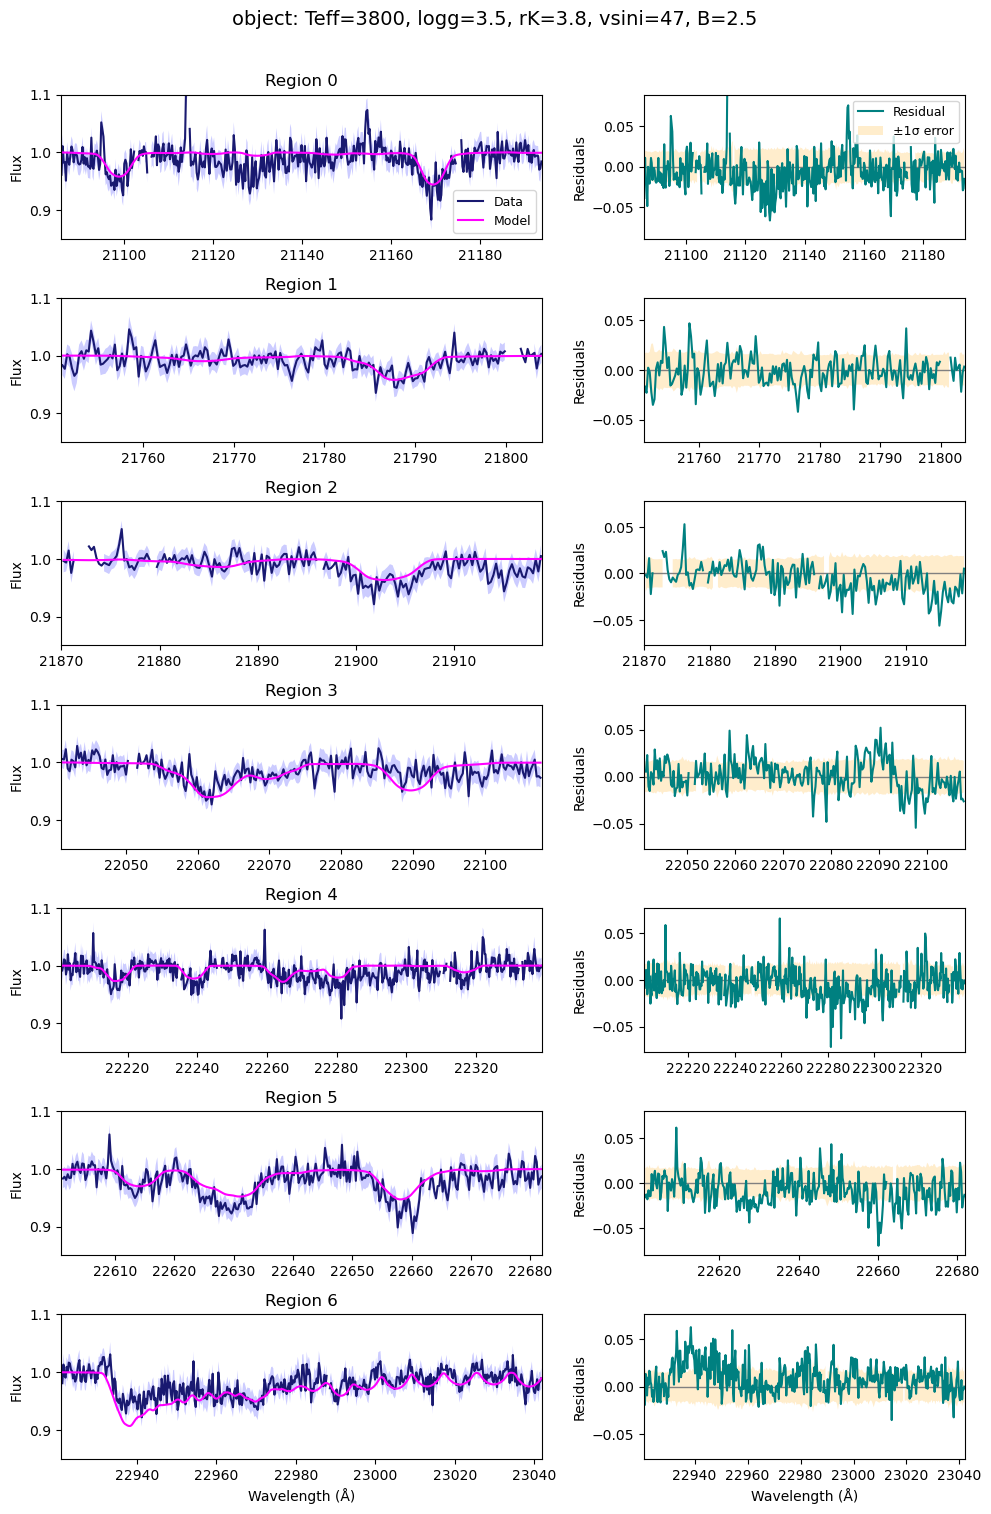

In [201]:
regions = [0, 1, 2, 3, 4, 5, 6]
best_params = (Teff_best, logg_best, rK_best, vsini_best, B_best)
plot_bestfit_and_residuals(data=obj, best_params=best_params, regions=regions, ylim=(0.85, 1.1))

# Reduced Chi-squared value

In [202]:
best_params = (Teff_best, logg_best, rK_best, vsini_best, B_best)
regions = [0, 1, 2, 3, 4, 5]  # or whatever regions you use

red_chi2 = compute_reduced_chi2_bestfit(data=obj, best_params=best_params, regions=regions)
print(f"Reduced chi-square at best fit: {red_chi2:.3f}")


Reduced chi-square at best fit: 1.040


# Chi-squared visualization

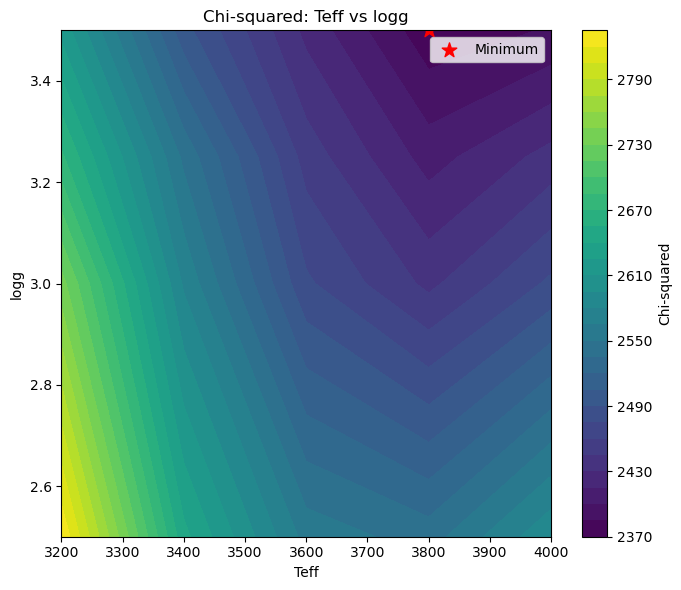

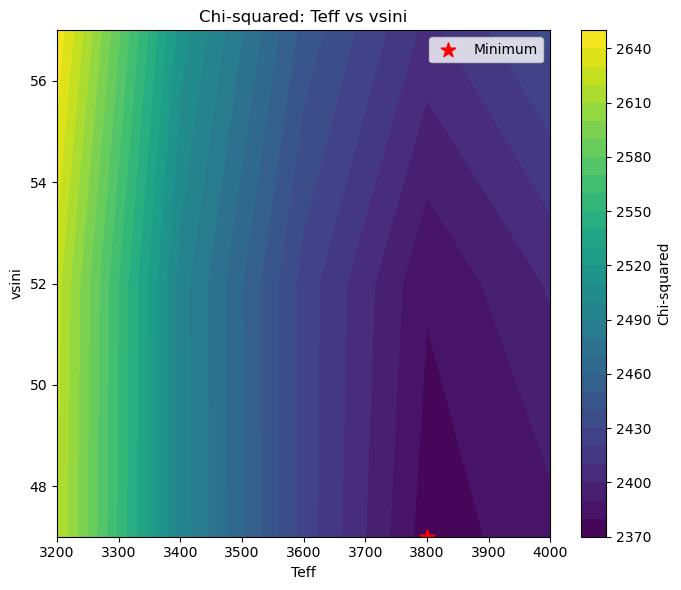

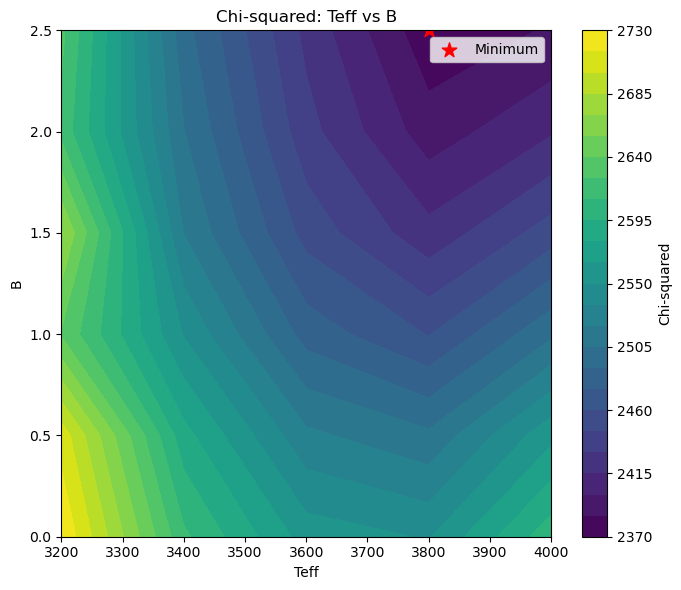

In [203]:
plot_chi2_slice(chi2_grid, Teff_vals, logg_vals, 'Teff', 'logg')
plot_chi2_slice(chi2_grid, Teff_vals, vsini_vals, 'Teff', 'vsini')
plot_chi2_slice(chi2_grid, Teff_vals, B_vals, 'Teff', 'B')

# Confidence intervals

In [204]:
param_grids = {'Teff': Teff_vals, 'logg': logg_vals, 'rK': rK_vals, 'vsini': vsini_vals, 'B': B_vals}
intervals = get_all_confidence_intervals(chi2_grid, param_grids, delta_chi2=1.0) # for 1 parameter at a time, 1-sigma
print(intervals)

{'Teff': (np.int64(3800), np.int64(3800)), 'logg': (np.float64(3.5), np.float64(3.5)), 'rK': (np.float64(3.7999999999999994), np.float64(3.7999999999999994)), 'vsini': (np.int64(47), np.int64(47)), 'B': (np.float64(2.5), np.float64(2.5))}


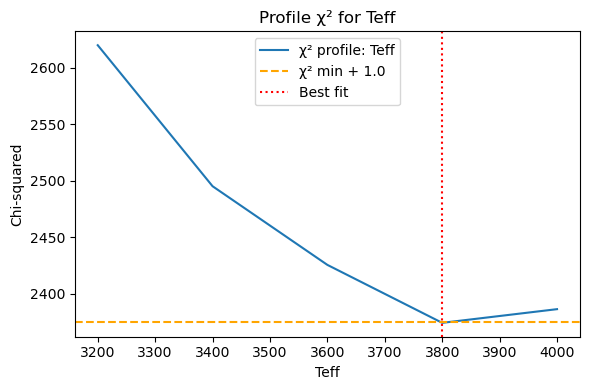

Best fit Teff: 3800
1.00 delta chi² confidence interval: (np.int64(3800), np.int64(3800))


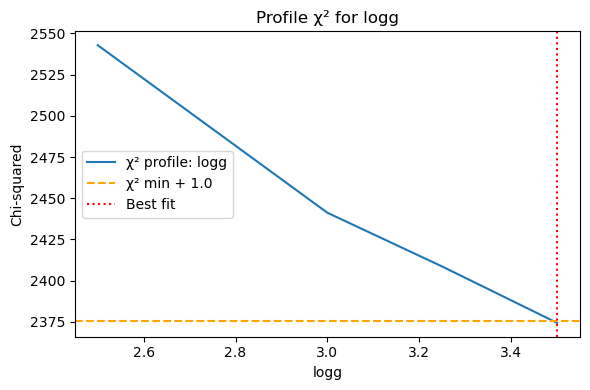

Best fit logg: 3.5
1.00 delta chi² confidence interval: (np.float64(3.5), np.float64(3.5))


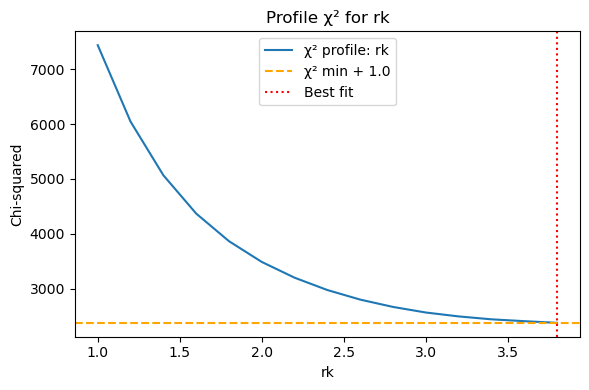

Best fit rk: 3.7999999999999994
1.00 delta chi² confidence interval: (np.float64(3.7999999999999994), np.float64(3.7999999999999994))


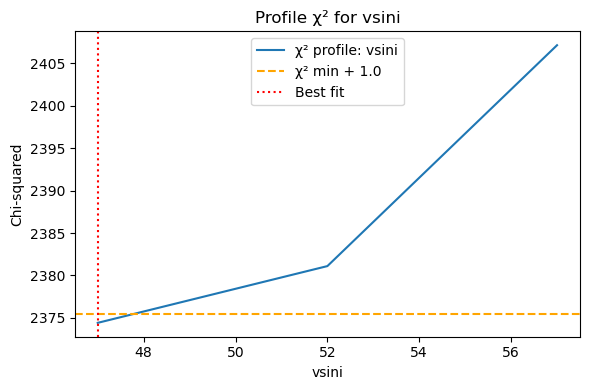

Best fit vsini: 47
1.00 delta chi² confidence interval: (np.int64(47), np.int64(47))


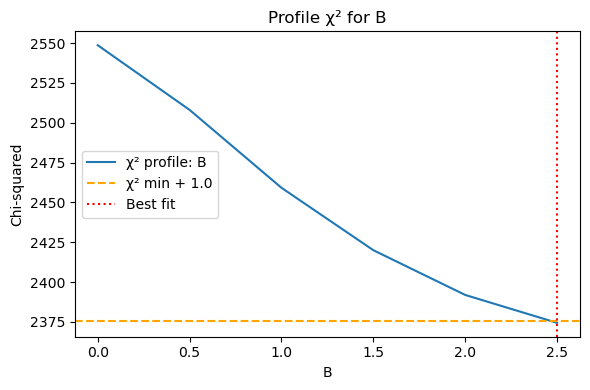

Best fit B: 2.5
1.00 delta chi² confidence interval: (np.float64(2.5), np.float64(2.5))


(np.float64(2.5), np.float64(2.5))

In [205]:
# For Teff (axis=0), 1-parameter interval:
plot_1d_chi2_profile(Teff_vals, chi2_grid, axis=0, param_name='Teff', delta_chi2=1.0)
plot_1d_chi2_profile(logg_vals, chi2_grid, axis=1, param_name='logg', delta_chi2=1.0)
plot_1d_chi2_profile(rK_vals, chi2_grid, axis=2, param_name='rk', delta_chi2=1.0)
plot_1d_chi2_profile(vsini_vals, chi2_grid, axis=3, param_name='vsini', delta_chi2=1.0)
plot_1d_chi2_profile(B_vals, chi2_grid, axis=4, param_name='B', delta_chi2=1.0)


# For logg (axis=1), etc.

## Plot with Feiden (2016) magnetic isochrones

In [206]:
# Import isochrones
model_ages = [1, 2, 4, 8, 15, 30, 50]          # in Myr
iso_models = []

for num in model_ages:
    fname = 'data/isochrones/dmestar_' + str(num) +'myr.txt'
    arr = np.loadtxt(fname, skiprows=5).T
    m = arr[0]
    teff = 10**arr[1]      # convert from logTeff to Teff
    logg = arr[2]
    iso_models.append([m, teff, logg])

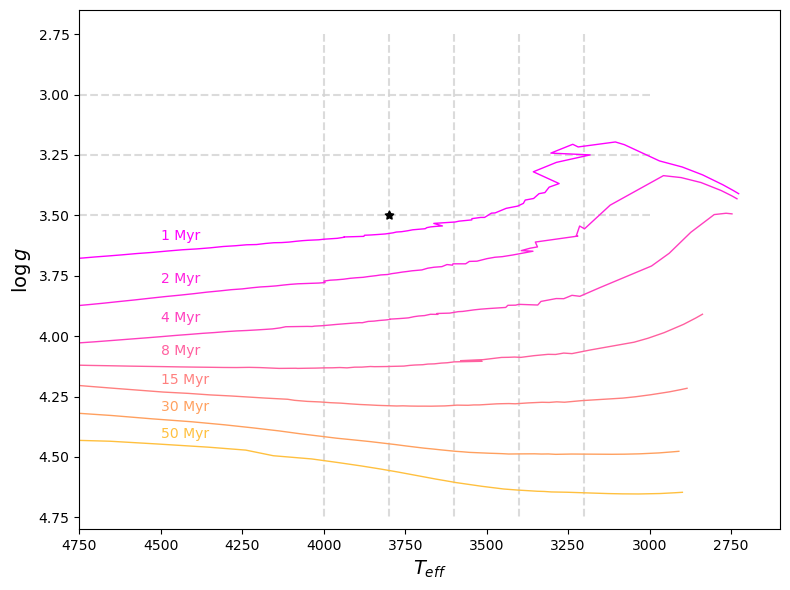

In [207]:
plt.figure(figsize=(8,6))

# Show objects as points
plt.scatter(Teff_best, logg_best, c='k', marker=(5, 1), s=40, zorder=2)

# Show grid of models
plt.vlines(Teff_vals, 2.75, 4.75, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)
plt.hlines(logg_vals, 3000, 4800, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)

# Plot isochrones and labels. Most of the complexity here is in shifting the text labels around so they
# look pretty on the figure...
n = 9
tshifts = [0, 0.02, 0.02, 0, -0.04, -0.09, -0.14]
colors = plt.cm.spring(np.linspace(0,1,n))
for i in range(len(model_ages)):
    plt.plot(iso_models[i][1], iso_models[i][2], zorder=1, label=str(model_ages[i]) + ' Myr', linewidth=1, c=colors[i])
    plt.text(4500, 3.6+0.16*i+tshifts[i], f"{model_ages[i]} Myr", c=colors[i], zorder=1)

plt.xlim(2600, 4750)
plt.ylim(2.65, 4.8)
plt.xlabel(r'$T_{eff}$', fontsize=14)
plt.ylabel(r'$\log g$', fontsize=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/ages_test.png', facecolor='white', dpi=98)
plt.show()